<a href="https://colab.research.google.com/github/PIRomanCod/DataSciense_HW/blob/main/HW_11_RNN_refactored%2Btransformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# В якості домашнього завдання вам пропонується створити рекурентну нейронну мережу за допомогою механізмів Keras, яка буде класифікувати рецензії із датасету imdb.

На відміну від прикладу в модулі 9 ми використаємо рекурентну нейронну мережу. Поекспериментуйте з будовою мережі - RNN, LSTM, двостороння та глибока.

Порівняйте результати та зробіть висновки.

## Імпорти

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=2430eed56cd60b82020c564097fe6a3e3c329d45549790ec45ce249aa22c841f
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, SimpleRNN, GRU, LSTM, Bidirectional
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras.metrics import Accuracy
from keras.models import load_model

from sklearn.metrics import confusion_matrix

import wandb
from wandb.keras import WandbMetricsLogger


## Встановлення констант та налаштування

In [ ]:
max_features = 10000  # кількість слів, що розглядаються як особливості
maxlen = 500  # обмеження кількості слів в тексті
batch_size = 128
n_epochs = 15
lr = 0.001
validation_split = 0.2

In [ ]:
best_of_models = {}

In [ ]:
path = "/content/drive/MyDrive/Colab_Notebooks/HW_11_data"

In [ ]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    os.environ["TF_DETERMINISTIC_OPS"] = "true"


set_seed(42)

In [ ]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=max_features)

17464789/17464789 [==============================] - 0s 0us/step


In [ ]:
# Подивимося розміри наборів даних
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((25000,), (25000,), (25000,), (25000,))

In [ ]:
# Передпроцесинг послідовних даних:
# Застосування заздалегідь обраної максимальної довжини до послідовних даних тренувального та тестового наборів

input_train = pad_sequences(train_data, maxlen=maxlen)
input_test = pad_sequences(test_data, maxlen=maxlen)

In [ ]:
# Ще раз подивимося на розміри ф'ючерів, що будуть подаватися до моделі
input_train.shape, input_test.shape

((25000, 500), (25000, 500))

## Словник для трансформацій до людскої мови

In [ ]:
word_index = imdb.get_word_index()

1641221/1641221 [==============================] - 0s 0us/step


### Подивимося зразок даних, що будуть подані до мережі у оригінальному вигляді

In [ ]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [ ]:
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

### А тепер у вигляді речення

In [ ]:
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## Створимо 5 моделей та навчимо їх, збережемо результати та виберемо найкращу з них для подальшого використання

In [ ]:
# Створення списку моделей та їх імен
models = []
model_names = ['SimpleRNN', 'RNN_GRU', 'RNN_LSTM', 'BRNN', 'Deep_BRNN']

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
157/157 [==============================] - ETA: 0s - loss: 0.5658 - accuracy: 0.7052
Epoch 1: val_accuracy improved from -inf to 0.80800, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_SimpleRNN.h5
157/157 [==============================] - 95s 599ms/step - loss: 0

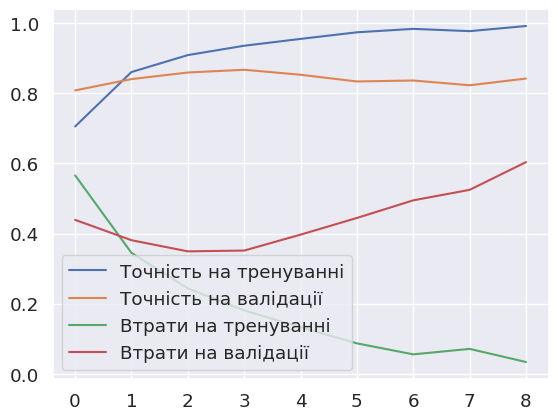

Best model SimpleRNN - Loss: 0.3723, Accuracy: 0.8547


epoch/accuracy,▁▅▆▇▇████
epoch/epoch,▁▂▃▄▅▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▂▂▁▁▁
epoch/val_accuracy,▁▅▇█▆▄▄▃▅
epoch/val_loss,▃▂▁▁▂▄▅▆█
epoch/accuracy,0.99155
epoch/epoch,8
epoch/learning_rate,0.001
epoch/loss,0.0337
epoch/val_accuracy,0.8418


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 32)          320000    
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 326,369
Trainable params: 326,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
157/157 [==============================] - ETA: 0s - loss: 0.5992 - accuracy: 0.6636
Epoch 1: val_accuracy improved from -inf to 0.79020, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_GRU.h5
157/157 [==============================] - 7s 29ms/step - loss: 0.599

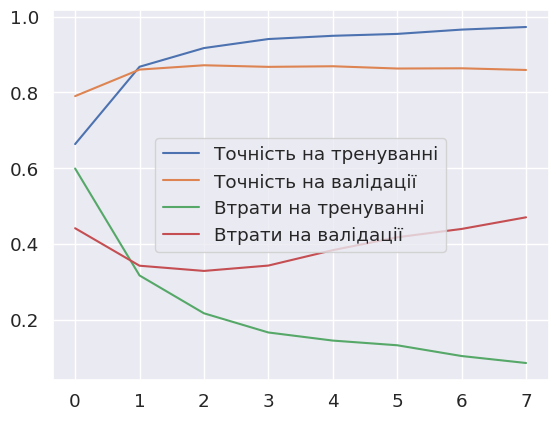

Best model RNN_GRU - Loss: 0.3383, Accuracy: 0.8662


epoch/accuracy,▁▆▇▇▇███
epoch/epoch,▁▂▃▄▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▁▁
epoch/val_accuracy,▁▇███▇▇▇
epoch/val_loss,▇▂▁▂▄▅▆█
epoch/accuracy,0.97255
epoch/epoch,7
epoch/learning_rate,0.001
epoch/loss,0.08603
epoch/val_accuracy,0.8592


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm_4 (LSTM)               (None, 32)                8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
156/157 [============================>.] - ETA: 0s - loss: 0.5270 - accuracy: 0.7330
Epoch 1: val_accuracy improved from -inf to 0.86080, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_LSTM.h5
157/157 [==============================] - 6s 30ms/step - loss: 0.52

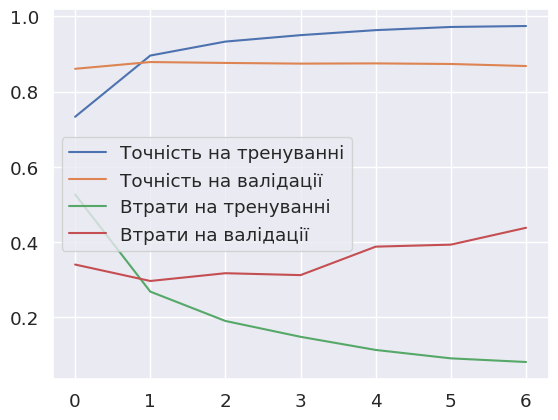

Best model RNN_LSTM - Loss: 0.3044, Accuracy: 0.8702


epoch/accuracy,▁▆▇▇███
epoch/epoch,▁▂▃▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▁▁
epoch/val_accuracy,▁█▇▆▇▆▄
epoch/val_loss,▃▁▂▂▆▆█
epoch/accuracy,0.97465
epoch/epoch,6
epoch/learning_rate,0.001
epoch/loss,0.08085
epoch/val_accuracy,0.8682


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 32)          320000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 336,705
Trainable params: 336,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
156/157 [============================>.] - ETA: 0s - loss: 0.5211 - accuracy: 0.7293
Epoch 1: val_accuracy improved from -inf to 0.85000, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_BRNN.h5
157/1

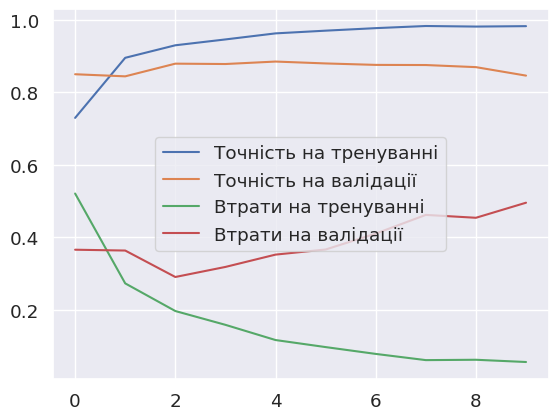

Best model BRNN - Loss: 0.3969, Accuracy: 0.8650


epoch/accuracy,▁▆▇▇▇█████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▁▁▁▁
epoch/val_accuracy,▂▁▇▇█▇▆▆▅▁
epoch/val_loss,▄▃▁▂▃▄▅▇▇█
epoch/accuracy,0.9827
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,0.05592
epoch/val_accuracy,0.8462


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 32)          320000    
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 64)         16640     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 361,537
Trainable params: 361,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
157/157 [===========================

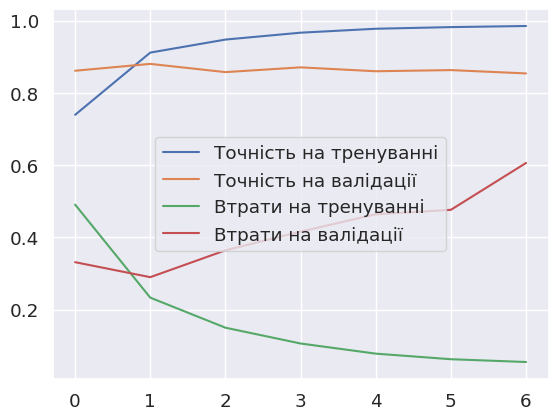

Best model Deep_BRNN - Loss: 0.3023, Accuracy: 0.8724


In [ ]:
# Створення та навчання моделей
for model_name in model_names:
    wandb.init(project=f"HW_11_{model_name}", config={"lr": lr, "n_epochs": n_epochs, "batch_size": batch_size})

    model = Sequential()
    model.add(Embedding(max_features, 32))

    if model_name == 'SimpleRNN':
        model.add(SimpleRNN(32))
    elif model_name == 'RNN_GRU':
        model.add(GRU(32))
    elif model_name == 'RNN_LSTM':
        model.add(LSTM(32))
    elif model_name == 'BRNN':
        model.add(Bidirectional(LSTM(32)))
    elif model_name == 'Deep_BRNN':
        model.add(Bidirectional(LSTM(32, return_sequences=True)))
        model.add(Bidirectional(LSTM(32)))

    model.add(Dense(1, activation='sigmoid'))

    early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)
    model_checkpoint_callback = ModelCheckpoint(
        path+f'/HW_11_best_model_{model_name}.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )
    callbacks = [early_stopping_callback, model_checkpoint_callback, WandbMetricsLogger()]

    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    history = model.fit(
        input_train, train_labels,
        epochs=n_epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=callbacks
    )

    best_model = load_model(path+f'/HW_11_best_model_{model_name}.h5')
    test_loss, test_accuracy = best_model.evaluate(input_test, test_labels)
    models.append(best_model)

    plt.plot(history.history['accuracy'], label='Точність на тренуванні')
    plt.plot(history.history['val_accuracy'], label='Точність на валідації')
    plt.plot(history.history['loss'], label='Втрати на тренуванні')
    plt.plot(history.history['val_loss'], label='Втрати на валідації')
    plt.legend()
    plt.show()

    best_of_models.update({model_name: test_accuracy})

    print(f"Best model {model_name} - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")


## Висновок для рекурентних мереж



In [ ]:
print("Результати тестів всіх побудованих моделей")
for item in best_of_models.items():
  print(item)

Результати тестів всіх побудованих моделей
('SimpleRNN', 0.8547199964523315)
('RNN_GRU', 0.8661999702453613)
('RNN_LSTM', 0.870199978351593)
('BRNN', 0.8650000095367432)
('Deep_BRNN', 0.8723999857902527)


## Спробуємо тест на реальних зразках

In [ ]:
# Список нових відгуків для перевірки
new_reviews = [
    "this movie was absolutely amazing!",
    "i didn't like this film at all. worst movie!",
    "the acting and storyline were both fantastic.",
    "terrible movie, waste of time.",
    "a must-watch for all movie lovers!",
    "I was blown away by how good this movie was.",
    "The direction and storytelling were not top-notch. waste",
    "This movie was more all my expectations. The performances were outstanding",
    "full lie",
]

# Мітки для нових відгуків
labels = [1, 0, 1, 0, 1, 1, 0, 1, 0]


In [ ]:

# Токенізація та векторизація нових відгуків
new_reviews_tokenized = [[word_index.get(word, -2) + 3 for word in review.split(" ")] for review in new_reviews]
new_reviews_vector = pad_sequences(new_reviews_tokenized, maxlen=maxlen)

# Перевірка кожної моделі на нових відгуках
for model, model_name in zip(models, model_names):
    results = model.predict(new_reviews_vector)
    binary_results = [1 if result > 0.5 else 0 for result in results]
    correct_predictions = sum([1 for predicted, actual in zip(binary_results, labels) if predicted == actual])

    print(f"Results for {model_name}:")
    for review, binary_result in zip(new_reviews, binary_results):
        print(f"Review: '{review}' - Binary Result: {binary_result}")

    print(f"Correct predictions: {correct_predictions} out of {len(new_reviews)}\n")

    # Побудова матриці плутанини та її візуалізація
    confusion_mat = confusion_matrix(labels, binary_results)
    sns.set(font_scale=1.2)
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Oranges", linewidths=1, linecolor="black",
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

In [ ]:
# Закінчення відправки даних до Weights & Biases
wandb.finish()

epoch/accuracy,▁▅▇▇████
epoch/epoch,▁▂▃▄▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▂▂▁▁▁
epoch/val_accuracy,▁▆█▇▇▇▇▇
epoch/val_loss,▄▂▁▃▄▆▆█
epoch/accuracy,0.98634
epoch/epoch,7
epoch/learning_rate,0.001
epoch/loss,0.05372
epoch/val_accuracy,0.868


## Після висновку - на нових сгенерованих відгуках тільки RNN_GRU (9 із 9), Deep_BRNN (8 із 9) та BRNN (7 із 9) показали результативність, інші дуже заоверфітилися

#  Спробуємо використати трансформери для вирішення задачі

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.6 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline

In [ ]:
pipe = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
# Перевіримо на рандомному висловлюванні
pipe("life can be easier")

[{'label': 'NEGATIVE', 'score': 0.9435901641845703}]

In [ ]:
# Приведемо до потрібного стану тестову вібірку
input_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [ ]:
test_labels[0]

0

In [ ]:
import re

In [ ]:
decoded_test = []
for sentense in input_test:
  decoded_review = ' '.join([reverse_word_index.get(i - 3, '.') for i in sentense]) #if i != 0
  clean_text = re.sub(r'[^\w\s]', '', decoded_review)
  decoded_test.append(clean_text)

In [ ]:
len(decoded_test)

25000

In [ ]:
# Подивимося на випадковий відгук
decoded_test[20000], test_labels[20000]

('                                                                                                                                                                                                                                                                                                              the concept of this movie is pretty compelling zombie children climbing out of an abandoned mine to seek revenge for their deaths in the backwoods of  cool the problem i had with the movie is the lack of creativity when dealing with the zombies the makers could have really  this film up with some terror like imagery a la the ring such as stop action reverse camera walking or stuff like that when the zombie children are  through the woods they look like a bunch of 9 year olds walking to a  in west philadelphia instead of pick  and  they could have easily been carrying baseball bats and  why would i fear these little kids anyone could just run away in a straight line to safety also who in 

In [ ]:
# Перевіримо на самостійно сформованих відгуках
res1 = []
true_res1 = []

# Проганяємо відгуки через pipeline та порівнюємо результати з мітками
for text, label in zip(new_reviews, labels):
    analysis = pipe(text[:1200])[0]  # Виконуємо аналіз для поточного відгука
    predicted_label = 1 if analysis['label'] == 'POSITIVE' else 0  # Перетворюємо мітку в 1 або 0
    res1.append(predicted_label)
    true_res1.append(label)

# Порівнюємо отримані результати з дійсними мітками
correct_predictions = [predicted == true for predicted, true in zip(res1, true_res1)]

# Обчислюємо точність
accuracy = sum(correct_predictions) / len(correct_predictions)

print("Accuracy:", accuracy)

Accuracy: 1.0


In [ ]:
# Перевіримо прогнавши тестову вибірку через pipeline
res = []
true_res = []

# Проганяємо відгуки через pipeline та порівнюємо результати з мітками (перші 1000 відгуків)
for text, label in zip(decoded_test, test_labels):
    analysis = pipe(text[:1000])[0]  # Виконуємо аналіз для поточного відгука, зрізаючи його довжину щоб не падав pipeline (перевищення 512 токенів)
    predicted_label = 1 if analysis['label'] == 'POSITIVE' else 0  # Перетворюємо мітку в 1 або 0
    res.append(predicted_label)
    true_res.append(label)

# Порівнюємо отримані результати з дійсними мітками
correct_predictions = [predicted == true for predicted, true in zip(res, true_res)]

# Обчислюємо точність
accuracy = sum(correct_predictions) / len(correct_predictions)

print("Accuracy:", accuracy)

Accuracy: 0.84272


## Суб висновок

pipeline "sentiment-analysis" з парку трансформерів не потребує навчання, при подачі відгуків майже миттево надає відповідь з точністю до 100%.

Перевірка на тестовій вибірці потребувала трансформування датасету до людської мови, та фільтрації, тому що частина слов не війшла до списку найуживаніших, та мусор заважав оцінці, проте це зайняло багато часу - близько 40 хвилин, та надало точність - 84.3%.

# Після всього - існує багато способів вирішення задач семантичного аналізу мови, як класичних: ліс рішень, рекурентні мережі, так більш модернові - трансформери, що мають високу швидкість та результативність. Вибір рішення залежить від конкретної задачі, уподобань розробника, та вимог замовника